In [5]:
import pandas as pd
import pdb
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 4,
    "device": 'cpu',
}

# Read the parquet file and get rough statistics

In [7]:
df = pd.read_parquet("enveda_chemist_annotations_hackathon.parquet.pq")
df.head()

<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject


,ground_truth_smiles,predicted_smiles,ground_truth_inchikey14,predicted_inchikey14,ground_truth_formula,predicted_formula,annotator_name,unable_to_assess,not_close_match,close_match,near_exact_match,exact_match,good_enough_for_prioritization,scaffold_correct,ground_truth_unable_to_annotate,ground_truth_has_scaffold,ground_truth_scaffold_smiles,ground_truth_scaffold_smarts
7,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,0,1,0,0,0,0,0,0,1,1,None,None
8,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,1,1,0,0,0,0,0,0,1,1,None,None
9,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,2,1,0,0,0,0,0,0,1,1,None,None
10,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,3,0,1,0,0,0,0,1,0,1,c1cc2c(c3C=CCOc3cc2)[nH]1,[#6]1:[#6]:[#6]2:[#6](:[#6]3-[#6]=[#6]-[#6]-[#...
11,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,4,1,0,0,0,0,0,0,1,1,None,None


In [8]:
print(df.shape)

(1667, 18)


## Compute label distribution to understand class imbalance

/var/folders/lc/2w4cj8jj4gv7hqz913wc9b4m0000gn/T/ipykernel_2956/2132284395.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)


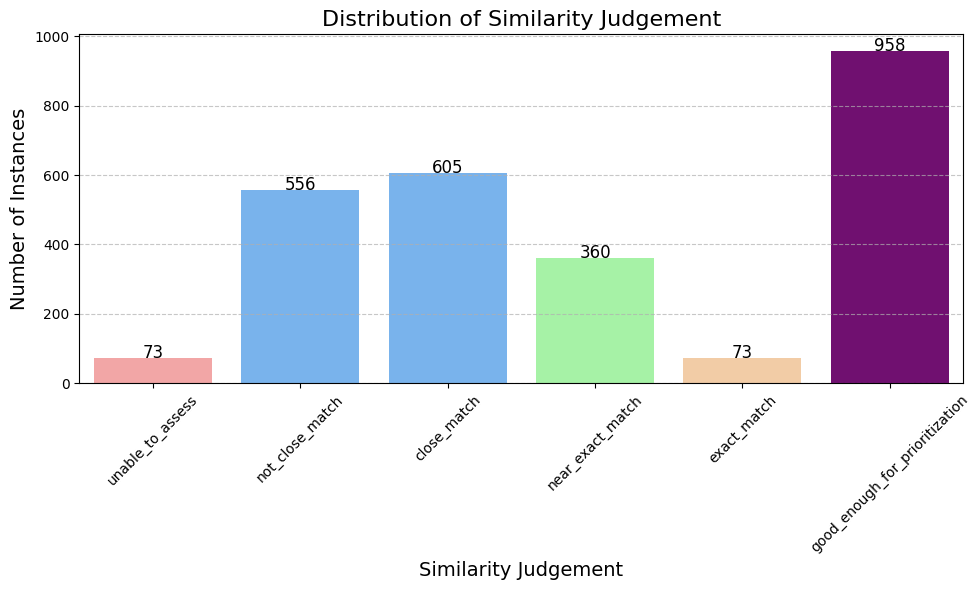

In [11]:
class_counts = df[['unable_to_assess', 'not_close_match','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']].sum()

# Define colors for each class
colors = ['#FF9999', '#66B3FF', '#66B3FF', '#99FF99', '#FFCC99', 'purple'] # Customize colors as needed

# Create a bar plot to visualize class imbalance
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.title('Distribution of Similarity Judgement', fontsize=16)
plt.xlabel('Similarity Judgement', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of the bars
for index, value in enumerate(class_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# Check for overlap in labels
labels = df[['unable_to_assess','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']]  # Select all rows and first five columns
# This will create a new DataFrame where each row is converted to a set of labels
overlap_check = labels.apply(lambda x: set(x), axis=1)

# Count how many rows have more than one label
multilabel_count = overlap_check.apply(lambda x: len(x) > 1).sum()

if multilabel_count > 0:
    print(f"There are {multilabel_count} instances with overlapping classes (multilabel classification).")
else:
    print("All instances have mutually exclusive classes (single-label classification).")

# Optional: Display the rows with overlapping classes for further inspection
if multilabel_count > 0:
    overlapping_rows = df[overlap_check.apply(lambda x: len(x) > 1)]
    print("Rows with overlapping classes:")
    print(overlapping_rows)

There are 1262 instances with overlapping classes (multilabel classification).
Rows with overlapping classes:
                                    ground_truth_smiles  \
7     CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
8     CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
9     CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
11    CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
12                           COc1ccc(OCCCS(=O)(=O)O)cc1   
...                                                 ...   
2329       CC=C1CN2C3CC1C1COC(c4c3[nH]c3cc(OC)ccc43)C12   
2330       CC=C1CN2C3CC1C1COC(c4c3[nH]c3cc(OC)ccc43)C12   
2332  CCC(C)c1[nH]c(O)c2n(c(O)c(Cc3ccccc3)[nH]c(O)c(...   
2333  CCC(C)c1[nH]c(O)c2n(c(O)c(Cc3ccccc3)[nH]c(O)c(...   
2335  CCC(C)c1[nH]c(O)c2n(c(O)c(Cc3ccccc3)[nH]c(O)c(...   

                                       predicted_smiles  \
7     CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...   
8     CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...   
9   

### Extract uniqiue smiles

In [36]:
# create a list of unique smiles

unique_smiles_gt = df['ground_truth_smiles'].unique()


In [38]:
len(unique_smiles)

401

# Load Feature Extractor
This notebook uses MolFormer, but feel free to use any of the latest feature extractors, like SPMM, Grover, SelFormer, among others.

In [13]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True).to(CONFIG['device'])
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py


# Extract features per row

### Fingerprint Embedding

In [18]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs


# Function to extract features
def extract_features(smiles):
    # Tokenize the SMILES string
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # pdb.set_trace()
    # Extract the last hidden state (embeddings)
    embeddings = outputs.pooler_output.cpu().numpy()
    return embeddings

def smiles_to_fingerprint(smile):
        """
        Convert SMILES string to concatenation of RDFKIT, Morgan and MACCSS fingerprints.
        """
        # RDFKIT (fingerprint dim fpSize=1024)
        x = Chem.MolFromSmiles(smile)
        fp1 = Chem.RDKFingerprint(x, fpSize=1024)

        # MACCSS substructure (fingerprint dim 167)
        fp2 = MACCSkeys.GenMACCSKeys(x)

        # Morgan (fingerprint dim fpSize=1024)
        fp_hashes = []
        fp3 = AllChem.GetHashedMorganFingerprint(x, 2, nBits=1024)
        fp3_array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp3, fp3_array)
        fp_hashes.append(fp3_array)

        # combine all fingerprints
        fp = fp1.ToBitString() + fp2.ToBitString()
        fp = np.array(list(fp)).astype(np.int8)
        fp = np.concatenate([fp] + fp_hashes)
        fp = torch.tensor(fp).to(torch.float32)
        return fp
    

In [19]:
df['ground_truth_fp'] = df['ground_truth_smiles'].apply(smiles_to_fingerprint)
df['predicted_fp'] = df['predicted_smiles'].apply(smiles_to_fingerprint)

In [21]:
df[['predicted_smiles', 'predicted_fp']].head()

,predicted_smiles,predicted_fp
7,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[tensor(1.), tensor(1.), tensor(1.), tensor(1...."
8,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[tensor(1.), tensor(1.), tensor(1.), tensor(1...."
9,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[tensor(1.), tensor(1.), tensor(1.), tensor(1...."
10,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[tensor(1.), tensor(1.), tensor(1.), tensor(1...."
11,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[tensor(1.), tensor(1.), tensor(1.), tensor(1...."


In [29]:
df['ground_truth_embeddings'] = df['ground_truth_smiles'].apply(extract_features)
df['predicted_embeddings'] = df['predicted_smiles'].apply(extract_features)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [30]:
df[['predicted_smiles', 'predicted_embeddings']].head()

,predicted_smiles,predicted_embeddings
7,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[[0.96212196, 0.038501173, 0.9624641, 0.423108..."
8,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[[0.96212196, 0.038501173, 0.9624641, 0.423108..."
9,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[[0.96212196, 0.038501173, 0.9624641, 0.423108..."
10,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[[0.96212196, 0.038501173, 0.9624641, 0.423108..."
11,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,"[[0.96212196, 0.038501173, 0.9624641, 0.423108..."


In [ ]:
print(df['predicted_embeddings'].iloc[42].shape)
df['predicted_embeddings'].iloc[42]

### Graph Embedding

In [28]:
# smiles to graphs
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

class GraphDatasetClass:
    '''
    Convert a dataframe of SMILES into a Pytorch Geometric Graph Dataset.
    https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
    '''

    def __init__(self):
        pass

    def one_hot_encoding(self, x, permitted_list):
        """
        Maps input elements x which are not in the permitted list to the last element
        of the permitted list.
        """

        if x not in permitted_list:
            x = permitted_list[-1]

        binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

        return binary_encoding


    def get_atom_features(self, atom,
                        use_chirality = True,
                        hydrogens_implicit = True):
        """
        Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
        """

        # define list of permitted atoms

        permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

        if hydrogens_implicit == False:
            permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

        # compute atom features

        atom_type_enc = self.one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

        n_heavy_neighbors_enc = self.one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

        formal_charge_enc = self.one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

        hybridisation_type_enc = self.one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

        is_in_a_ring_enc = [int(atom.IsInRing())]

        is_aromatic_enc = [int(atom.GetIsAromatic())]

        atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

        vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

        covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

        atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

        if use_chirality == True:
            chirality_type_enc = self.one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
            atom_feature_vector += chirality_type_enc

        if hydrogens_implicit == True:
            n_hydrogens_enc = self.one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
            atom_feature_vector += n_hydrogens_enc

        return np.array(atom_feature_vector)

    def get_bond_features(self, bond,
                        use_stereochemistry = True):
        """
        Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
        """

        permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

        bond_type_enc = self.one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

        bond_is_conj_enc = [int(bond.GetIsConjugated())]

        bond_is_in_ring_enc = [int(bond.IsInRing())]

        bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

        if use_stereochemistry == True:
            stereo_type_enc = self.one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
            bond_feature_vector += stereo_type_enc

        return np.array(bond_feature_vector)

    def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(self, x_smiles):
        """
        Inputs:

        x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
        y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

        Outputs:

        data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

        """

        data_list = []

        for smiles in tqdm(x_smiles, desc='Creating graph dataset...', total=len(x_smiles)):

            # convert SMILES to RDKit mol object
            mol = Chem.MolFromSmiles(smiles)

            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(self.get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(self.get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = self.get_atom_features(atom)

            X = torch.tensor(X, dtype = torch.float)

            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)

            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))

            for (k, (i,j)) in enumerate(zip(rows, cols)):

                EF[k] = self.get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

            EF = torch.tensor(EF, dtype = torch.float)


            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF))

        return data_list

In [ ]:
def prepare_datalist(smiles, args, graph_fp=True, grover_fp=None):
    '''
    Convert matrix dataframe to a data_list with pytorch geometric graph data, fingerprints and labels.
    Inputs:
        matrix_df: dataframe of SMILES, assays and bioactivity labels
        args: arguments
        graph_fp: if True, includes graph embedding fingerprints into data_list
        grover_fp: if True, includes GROVER graph transformer embedding fingerprints into data_list
    Outputs:
        data_list: list of data objects
    '''

    # get SMILES strings
    data = smiles


    # add graph fingerprint
    if graph_fp is True: 
        GraphDataset = GraphDatasetClass()
        # create pytorch geometric graph data list
        data_list = GraphDataset.create_pytorch_geometric_graph_data_list_from_smiles_and_labels(data)
   
    else: # create simple data_list without graph fingerprint
      data_list = []
    #   for label in y:
    #       # construct Pytorch Geometric data object and append to data list
    #       data_list.append(Data(y = label.reshape(1, -1)))
    
    
    # add fingerprint data to each graph
    for i, smile in tqdm(enumerate(data), desc='Adding fingerprints...', total=len(data)):
        fp = convert_smile_to_fp_bit_string(smile)
        data_list[i].fp = fp 


    # add grover fingerprint to each graph
    if grover_fp is not None:
        for i, gfp in tqdm(enumerate(grover_fp['fps'][:args['num_data_points']]), desc='Adding grover embedding...', total=len(data)):
          data_list[i].grover_fp = torch.tensor(gfp)


    print(f'Example of a graph data object: {data_list[0]}')

    return data_list

# Save into pickle file for reuse and avoid recomputing features

In [31]:
# Save the DataFrame to a pickle file
df.to_pickle('enveda_chemist_preprocessed.pkl')